# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val1_resnet34_mixup_warmup"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 320,
    "model_name": "resnet34",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-7,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "use_tta": False,
    "mixup_alpha": 0.4,  # 既存のMixupのパラメータ
    "mixup_epochs": 40,  # Mixupを適用するエポック数を追加
    "dropout_rate": 0.2,
    "warmup_steps": 45,  # Warmupのステップ数を追加
    "warmup_factor": 0.02,  # 初期学習率の倍率
    "save_preds": True,
    "save_dir": "../proc/preds",
}

# Set Seed for Reproducibility

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [5]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [6]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [7]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [8]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [9]:
df_patient = df.groupby("patient_id")[["isic_id"]].agg(
    count_per_patient=("isic_id", "count"), 
).sort_values(by="count_per_patient").reset_index()
df_patient.head(2)

,patient_id,count_per_patient
0,IP_5792391,1
1,IP_1487179,1


In [10]:
df = df.merge(df_patient, on="patient_id", how="left")
df.shape[0], df.target.sum()

(401059, 393)

In [11]:
df.shape[0], df.target.sum()

(401059, 393)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [12]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [13]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [14]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [17]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None, dropout_rate=CONFIG['dropout_rate']):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        # ResNetの場合はclassifierではなくfcを使用
        in_features = self.model.fc.in_features
        self.model.fc = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        dropped_features = self.dropout(pooled_features)
        output = self.sigmoid(self.linear(dropped_features))
        return output


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [18]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)
#     return nn.CrossEntropyLoss()(outputs, targets) 

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [19]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [20]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [21]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [22]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = f"training_fold{fold}"
    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append(scheduler.get_last_lr()[0])
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc:.5f} ---> {val_epoch_auroc:.5f})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            # 過去のベストモデルを削除
#             if 'PATH' in locals():
#                 os.remove(PATH)
            PATH = "training_fold{}/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(fold, val_epoch_auroc, val_epoch_loss, epoch)

        else:
            print(f"Validation pAUC80 not Improved ({val_epoch_auroc:.5f})")

        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # torch.save(best_model_wts, PATH)
    # Save a model file from the current directory
    # print(f"Best Model Saved{sr_}")
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, history

In [23]:
class WarmupScheduler:
    def __init__(self, optimizer, warmup_steps, warmup_factor, base_scheduler):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.warmup_factor = warmup_factor
        self.base_scheduler = base_scheduler
        self.current_step = 0

    def step(self):
        self.current_step += 1
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr_scale * param_group['initial_lr']
        else:
            self.base_scheduler.step()

    def get_last_lr(self):
        if self.current_step < self.warmup_steps:
            lr_scale = self.warmup_factor + (1 - self.warmup_factor) * (self.current_step / self.warmup_steps)
            return [lr_scale * param_group['initial_lr'] for param_group in self.optimizer.param_groups]
        else:
            return self.base_scheduler.get_last_lr()

def fetch_scheduler(optimizer, T_max=None):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        base_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        base_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CONFIG['T_0'], eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    return WarmupScheduler(optimizer, CONFIG['warmup_steps'], CONFIG['warmup_factor'], base_scheduler)


In [24]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [25]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images", name=EXP_NAME, config=wandb_config)

In [26]:
list_score_notFiltered = []
list_preds = []
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]

    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    # optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], 
    #                         weight_decay=CONFIG['weight_decay'])
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"] - CONFIG["warmup_steps"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)

    #########################
    # valの全データでスコア確認
    #########################
    df_val = df[df["kfold"]==fold]
    df_val_pred = df_val[["isic_id", "kfold", "target"]]
    
    valid_dataset = ISICDataset(df_val, transforms=data_transforms["valid"])
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    preds = []
    with torch.no_grad():
        bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, data in bar:        
            images = data['image'].to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images).squeeze()
            preds.extend(outputs.detach().cpu().numpy().flatten())
    
    df_val_pred["preds"] = preds
    list_preds.append(df_val_pred)

    # マルチクラス用のpAUC計算
    epoch_pauc = comp_score_list(df_val["target"].to_list(), preds)
    print(f"fold{fold}_pAUC (not filtered): {epoch_pauc:.4f}")
    list_score_notFiltered.append(epoch_pauc)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 58) 320 (835,)
filtered> (6720, 58) 320 (765,)
●val
original> (94479, 58) 73 (207,)
filtered> (1533, 58) 73 (180,)


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  4.94it/s, Epoch=1, LR=0.000238, Valid_Loss=0.654]


Validation AUROC Improved (-inf ---> 0.02408)



100%|██████████| 12/12 [00:01<00:00,  6.06it/s, Epoch=2, LR=0.000456, Valid_Loss=0.556]


Validation AUROC Improved (0.02408 ---> 0.03451)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=3, LR=0.000673, Valid_Loss=0.757]


Validation AUROC Improved (0.03451 ---> 0.06059)



100%|██████████| 12/12 [00:01<00:00,  6.29it/s, Epoch=4, LR=0.000891, Valid_Loss=0.616]


Validation pAUC80 not Improved (0.04940)



100%|██████████| 12/12 [00:01<00:00,  6.07it/s, Epoch=5, LR=0.000978, Valid_Loss=0.564]


Validation AUROC Improved (0.06059 ---> 0.06766)



100%|██████████| 12/12 [00:01<00:00,  6.20it/s, Epoch=6, LR=0.000975, Valid_Loss=0.646]


Validation AUROC Improved (0.06766 ---> 0.08182)



100%|██████████| 12/12 [00:01<00:00,  6.10it/s, Epoch=7, LR=0.00097, Valid_Loss=1]    


Validation pAUC80 not Improved (0.07672)



100%|██████████| 12/12 [00:01<00:00,  6.09it/s, Epoch=8, LR=0.000963, Valid_Loss=0.478]


Validation AUROC Improved (0.08182 ---> 0.08737)



100%|██████████| 12/12 [00:01<00:00,  6.42it/s, Epoch=9, LR=0.000954, Valid_Loss=0.526]


Validation AUROC Improved (0.08737 ---> 0.10312)



100%|██████████| 12/12 [00:01<00:00,  6.35it/s, Epoch=10, LR=0.000942, Valid_Loss=0.371]


Validation pAUC80 not Improved (0.09460)



100%|██████████| 12/12 [00:01<00:00,  6.02it/s, Epoch=11, LR=0.000928, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.09284)



100%|██████████| 12/12 [00:02<00:00,  5.85it/s, Epoch=12, LR=0.000912, Valid_Loss=0.512]


Validation pAUC80 not Improved (0.09877)



100%|██████████| 12/12 [00:02<00:00,  5.92it/s, Epoch=13, LR=0.000895, Valid_Loss=0.456]


Validation pAUC80 not Improved (0.09226)



100%|██████████| 12/12 [00:02<00:00,  5.79it/s, Epoch=14, LR=0.000875, Valid_Loss=0.271]


Validation pAUC80 not Improved (0.09053)



100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=15, LR=0.000853, Valid_Loss=0.426]


Validation AUROC Improved (0.10312 ---> 0.10503)



100%|██████████| 12/12 [00:02<00:00,  5.83it/s, Epoch=16, LR=0.00083, Valid_Loss=0.276]


Validation pAUC80 not Improved (0.10030)



100%|██████████| 12/12 [00:02<00:00,  5.63it/s, Epoch=17, LR=0.000805, Valid_Loss=0.461]


Validation pAUC80 not Improved (0.10077)



100%|██████████| 12/12 [00:02<00:00,  5.74it/s, Epoch=18, LR=0.000778, Valid_Loss=0.248]


Validation AUROC Improved (0.10503 ---> 0.10695)



100%|██████████| 12/12 [00:02<00:00,  5.75it/s, Epoch=19, LR=0.00075, Valid_Loss=0.333]


Validation pAUC80 not Improved (0.09529)



100%|██████████| 12/12 [00:02<00:00,  5.61it/s, Epoch=20, LR=0.000721, Valid_Loss=0.324]


Validation pAUC80 not Improved (0.09451)



100%|██████████| 12/12 [00:02<00:00,  5.86it/s, Epoch=21, LR=0.000691, Valid_Loss=0.427]


Validation pAUC80 not Improved (0.09727)



100%|██████████| 12/12 [00:02<00:00,  5.84it/s, Epoch=22, LR=0.000659, Valid_Loss=0.326]


Validation pAUC80 not Improved (0.09233)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=23, LR=0.000627, Valid_Loss=0.394]


Validation AUROC Improved (0.10695 ---> 0.10839)



100%|██████████| 12/12 [00:02<00:00,  5.71it/s, Epoch=24, LR=0.000595, Valid_Loss=0.274]


Validation pAUC80 not Improved (0.10274)



100%|██████████| 12/12 [00:02<00:00,  5.75it/s, Epoch=25, LR=0.000561, Valid_Loss=0.336]


Validation AUROC Improved (0.10839 ---> 0.11108)



100%|██████████| 12/12 [00:02<00:00,  5.80it/s, Epoch=26, LR=0.000528, Valid_Loss=0.346]


Validation pAUC80 not Improved (0.10656)



100%|██████████| 12/12 [00:02<00:00,  5.72it/s, Epoch=27, LR=0.000494, Valid_Loss=0.351]


Validation pAUC80 not Improved (0.10830)



100%|██████████| 12/12 [00:02<00:00,  5.72it/s, Epoch=28, LR=0.00046, Valid_Loss=0.352]


Validation AUROC Improved (0.11108 ---> 0.12023)



100%|██████████| 12/12 [00:01<00:00,  6.04it/s, Epoch=29, LR=0.000427, Valid_Loss=0.277]


Validation pAUC80 not Improved (0.10403)



100%|██████████| 12/12 [00:02<00:00,  5.79it/s, Epoch=30, LR=0.000394, Valid_Loss=0.302]


Validation pAUC80 not Improved (0.11249)



100%|██████████| 12/12 [00:02<00:00,  5.75it/s, Epoch=31, LR=0.000361, Valid_Loss=0.34] 


Validation AUROC Improved (0.12023 ---> 0.12494)



100%|██████████| 12/12 [00:02<00:00,  5.83it/s, Epoch=32, LR=0.000328, Valid_Loss=0.305]


Validation pAUC80 not Improved (0.12401)



100%|██████████| 12/12 [00:02<00:00,  5.74it/s, Epoch=33, LR=0.000297, Valid_Loss=0.336]


Validation pAUC80 not Improved (0.11269)



100%|██████████| 12/12 [00:02<00:00,  5.74it/s, Epoch=34, LR=0.000266, Valid_Loss=0.332]


Validation pAUC80 not Improved (0.11037)



100%|██████████| 12/12 [00:02<00:00,  5.68it/s, Epoch=35, LR=0.000237, Valid_Loss=0.357]


Validation pAUC80 not Improved (0.12361)



100%|██████████| 12/12 [00:02<00:00,  5.98it/s, Epoch=36, LR=0.000209, Valid_Loss=0.302]


Validation pAUC80 not Improved (0.11768)



100%|██████████| 12/12 [00:02<00:00,  5.80it/s, Epoch=37, LR=0.000182, Valid_Loss=0.268]


Validation pAUC80 not Improved (0.11547)



100%|██████████| 12/12 [00:02<00:00,  5.87it/s, Epoch=38, LR=0.000156, Valid_Loss=0.275]


Validation pAUC80 not Improved (0.11533)



100%|██████████| 12/12 [00:02<00:00,  5.75it/s, Epoch=39, LR=0.000132, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.11872)



100%|██████████| 12/12 [00:01<00:00,  6.03it/s, Epoch=40, LR=0.00011, Valid_Loss=0.341]


Validation pAUC80 not Improved (0.12182)



100%|██████████| 12/12 [00:02<00:00,  5.72it/s, Epoch=41, LR=8.96e-5, Valid_Loss=0.29] 


Validation pAUC80 not Improved (0.11626)



100%|██████████| 12/12 [00:02<00:00,  5.42it/s, Epoch=42, LR=7.11e-5, Valid_Loss=0.274]


Validation pAUC80 not Improved (0.11317)



100%|██████████| 12/12 [00:02<00:00,  5.43it/s, Epoch=43, LR=5.46e-5, Valid_Loss=0.282]


Validation pAUC80 not Improved (0.11779)



100%|██████████| 12/12 [00:02<00:00,  5.77it/s, Epoch=44, LR=4.01e-5, Valid_Loss=0.283]


Validation pAUC80 not Improved (0.11680)



100%|██████████| 12/12 [00:02<00:00,  5.68it/s, Epoch=45, LR=2.78e-5, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.11512)



100%|██████████| 12/12 [00:02<00:00,  5.89it/s, Epoch=46, LR=1.77e-5, Valid_Loss=0.289]


Validation pAUC80 not Improved (0.11684)



100%|██████████| 12/12 [00:02<00:00,  5.85it/s, Epoch=47, LR=9.87e-6, Valid_Loss=0.289]


Validation pAUC80 not Improved (0.11562)



100%|██████████| 12/12 [00:02<00:00,  5.77it/s, Epoch=48, LR=4.3e-6, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.11930)



100%|██████████| 12/12 [00:02<00:00,  5.86it/s, Epoch=49, LR=1.04e-6, Valid_Loss=0.273]


Validation pAUC80 not Improved (0.11939)



100%|██████████| 12/12 [00:02<00:00,  5.72it/s, Epoch=50, LR=1.12e-7, Valid_Loss=0.27] 


Validation pAUC80 not Improved (0.11509)

Training complete in 0h 3m 54s
Best AUROC: 0.1249


100%|██████████| 739/739 [01:44<00:00,  7.08it/s]


fold0_pAUC (not filtered): 0.1152
fold 1
●train
original> (315046, 58) 297 (833,)
filtered> (6237, 58) 297 (751,)
●val
original> (86013, 58) 96 (209,)
filtered> (2016, 58) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:02<00:00,  7.08it/s, Epoch=1, LR=0.000216, Valid_Loss=0.656]


Validation AUROC Improved (-inf ---> 0.03240)



100%|██████████| 16/16 [00:02<00:00,  6.97it/s, Epoch=2, LR=0.000412, Valid_Loss=0.727]


Validation AUROC Improved (0.03240 ---> 0.04702)



100%|██████████| 16/16 [00:02<00:00,  7.13it/s, Epoch=3, LR=0.000608, Valid_Loss=0.536]


Validation pAUC80 not Improved (0.03115)



100%|██████████| 16/16 [00:02<00:00,  7.19it/s, Epoch=4, LR=0.000804, Valid_Loss=0.61] 


Validation AUROC Improved (0.04702 ---> 0.06418)



100%|██████████| 16/16 [00:02<00:00,  7.32it/s, Epoch=5, LR=0.000978, Valid_Loss=0.499]


Validation AUROC Improved (0.06418 ---> 0.09486)



100%|██████████| 16/16 [00:02<00:00,  7.24it/s, Epoch=6, LR=0.000977, Valid_Loss=1.19]


Validation AUROC Improved (0.09486 ---> 0.10140)



100%|██████████| 16/16 [00:02<00:00,  7.29it/s, Epoch=7, LR=0.000973, Valid_Loss=0.56] 


Validation AUROC Improved (0.10140 ---> 0.10150)



100%|██████████| 16/16 [00:02<00:00,  7.25it/s, Epoch=8, LR=0.000967, Valid_Loss=0.507]


Validation AUROC Improved (0.10150 ---> 0.10349)



100%|██████████| 16/16 [00:02<00:00,  7.19it/s, Epoch=9, LR=0.000958, Valid_Loss=0.542]


Validation AUROC Improved (0.10349 ---> 0.11211)



100%|██████████| 16/16 [00:02<00:00,  7.16it/s, Epoch=10, LR=0.000947, Valid_Loss=0.506]


Validation AUROC Improved (0.11211 ---> 0.11217)



100%|██████████| 16/16 [00:02<00:00,  7.21it/s, Epoch=11, LR=0.000934, Valid_Loss=0.79] 


Validation AUROC Improved (0.11217 ---> 0.12633)



100%|██████████| 16/16 [00:02<00:00,  7.28it/s, Epoch=12, LR=0.000919, Valid_Loss=0.26] 


Validation pAUC80 not Improved (0.12334)



100%|██████████| 16/16 [00:02<00:00,  7.46it/s, Epoch=13, LR=0.000902, Valid_Loss=0.496]


Validation pAUC80 not Improved (0.11566)



100%|██████████| 16/16 [00:02<00:00,  7.51it/s, Epoch=14, LR=0.000883, Valid_Loss=0.299]


Validation pAUC80 not Improved (0.10948)



100%|██████████| 16/16 [00:02<00:00,  7.32it/s, Epoch=15, LR=0.000861, Valid_Loss=0.448]


Validation pAUC80 not Improved (0.11575)



100%|██████████| 16/16 [00:02<00:00,  7.13it/s, Epoch=16, LR=0.000838, Valid_Loss=0.491]


Validation pAUC80 not Improved (0.12533)



100%|██████████| 16/16 [00:02<00:00,  6.89it/s, Epoch=17, LR=0.000814, Valid_Loss=0.406]


Validation pAUC80 not Improved (0.11402)



100%|██████████| 16/16 [00:02<00:00,  7.24it/s, Epoch=18, LR=0.000787, Valid_Loss=0.521]


Validation AUROC Improved (0.12633 ---> 0.12801)



100%|██████████| 16/16 [00:02<00:00,  7.31it/s, Epoch=19, LR=0.000759, Valid_Loss=0.353]


Validation AUROC Improved (0.12801 ---> 0.13181)



100%|██████████| 16/16 [00:02<00:00,  7.41it/s, Epoch=20, LR=0.00073, Valid_Loss=0.431]


Validation AUROC Improved (0.13181 ---> 0.13404)



100%|██████████| 16/16 [00:02<00:00,  7.52it/s, Epoch=21, LR=0.0007, Valid_Loss=0.368]


Validation pAUC80 not Improved (0.12854)



100%|██████████| 16/16 [00:02<00:00,  6.50it/s, Epoch=22, LR=0.000669, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.12847)



100%|██████████| 16/16 [00:02<00:00,  7.11it/s, Epoch=23, LR=0.000637, Valid_Loss=0.293]


Validation pAUC80 not Improved (0.13053)



100%|██████████| 16/16 [00:02<00:00,  7.28it/s, Epoch=24, LR=0.000604, Valid_Loss=0.445]


Validation pAUC80 not Improved (0.12779)



100%|██████████| 16/16 [00:02<00:00,  7.23it/s, Epoch=25, LR=0.00057, Valid_Loss=0.295]


Validation AUROC Improved (0.13404 ---> 0.13639)



100%|██████████| 16/16 [00:02<00:00,  7.60it/s, Epoch=26, LR=0.000537, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.13339)



100%|██████████| 16/16 [00:02<00:00,  7.30it/s, Epoch=27, LR=0.000502, Valid_Loss=0.388]


Validation pAUC80 not Improved (0.13031)



100%|██████████| 16/16 [00:02<00:00,  7.23it/s, Epoch=28, LR=0.000468, Valid_Loss=0.269]


Validation pAUC80 not Improved (0.13079)



100%|██████████| 16/16 [00:02<00:00,  7.33it/s, Epoch=29, LR=0.000434, Valid_Loss=0.392]


Validation pAUC80 not Improved (0.13077)



100%|██████████| 16/16 [00:02<00:00,  7.28it/s, Epoch=30, LR=0.000401, Valid_Loss=0.418]


Validation pAUC80 not Improved (0.12296)



100%|██████████| 16/16 [00:02<00:00,  7.47it/s, Epoch=31, LR=0.000367, Valid_Loss=0.377]


Validation pAUC80 not Improved (0.13194)



100%|██████████| 16/16 [00:02<00:00,  7.26it/s, Epoch=32, LR=0.000334, Valid_Loss=0.362]


Validation AUROC Improved (0.13639 ---> 0.14183)



100%|██████████| 16/16 [00:02<00:00,  7.36it/s, Epoch=33, LR=0.000302, Valid_Loss=0.319]


Validation AUROC Improved (0.14183 ---> 0.14261)



100%|██████████| 16/16 [00:02<00:00,  7.40it/s, Epoch=34, LR=0.000271, Valid_Loss=0.267]


Validation pAUC80 not Improved (0.13585)



100%|██████████| 16/16 [00:02<00:00,  7.38it/s, Epoch=35, LR=0.000241, Valid_Loss=0.281]


Validation pAUC80 not Improved (0.13753)



100%|██████████| 16/16 [00:02<00:00,  7.26it/s, Epoch=36, LR=0.000213, Valid_Loss=0.32] 


Validation pAUC80 not Improved (0.13981)



100%|██████████| 16/16 [00:02<00:00,  7.42it/s, Epoch=37, LR=0.000185, Valid_Loss=0.372]


Validation pAUC80 not Improved (0.13832)



100%|██████████| 16/16 [00:02<00:00,  7.34it/s, Epoch=38, LR=0.000159, Valid_Loss=0.321]


Validation pAUC80 not Improved (0.13590)



100%|██████████| 16/16 [00:02<00:00,  7.38it/s, Epoch=39, LR=0.000135, Valid_Loss=0.275]


Validation pAUC80 not Improved (0.13553)



100%|██████████| 16/16 [00:02<00:00,  7.12it/s, Epoch=40, LR=0.000112, Valid_Loss=0.351]


Validation pAUC80 not Improved (0.13262)



100%|██████████| 16/16 [00:02<00:00,  7.17it/s, Epoch=41, LR=9.13e-5, Valid_Loss=0.316]


Validation pAUC80 not Improved (0.13668)



100%|██████████| 16/16 [00:02<00:00,  7.26it/s, Epoch=42, LR=7.24e-5, Valid_Loss=0.288]


Validation pAUC80 not Improved (0.13957)



100%|██████████| 16/16 [00:02<00:00,  7.31it/s, Epoch=43, LR=5.56e-5, Valid_Loss=0.297]


Validation AUROC Improved (0.14261 ---> 0.14366)



100%|██████████| 16/16 [00:02<00:00,  6.91it/s, Epoch=44, LR=4.09e-5, Valid_Loss=0.304]


Validation AUROC Improved (0.14366 ---> 0.14388)



100%|██████████| 16/16 [00:02<00:00,  7.13it/s, Epoch=45, LR=2.83e-5, Valid_Loss=0.285]


Validation pAUC80 not Improved (0.14355)



100%|██████████| 16/16 [00:02<00:00,  7.19it/s, Epoch=46, LR=1.8e-5, Valid_Loss=0.279]


Validation AUROC Improved (0.14388 ---> 0.14460)



100%|██████████| 16/16 [00:02<00:00,  6.71it/s, Epoch=47, LR=1e-5, Valid_Loss=0.282]


Validation AUROC Improved (0.14460 ---> 0.14463)



100%|██████████| 16/16 [00:02<00:00,  7.54it/s, Epoch=48, LR=4.35e-6, Valid_Loss=0.284]


Validation AUROC Improved (0.14463 ---> 0.14487)



100%|██████████| 16/16 [00:02<00:00,  7.37it/s, Epoch=49, LR=1.04e-6, Valid_Loss=0.27] 


Validation pAUC80 not Improved (0.14434)



100%|██████████| 16/16 [00:02<00:00,  7.18it/s, Epoch=50, LR=1.15e-7, Valid_Loss=0.283]


Validation pAUC80 not Improved (0.14442)

Training complete in 0h 3m 49s
Best AUROC: 0.1449


100%|██████████| 672/672 [01:16<00:00,  8.79it/s]


fold1_pAUC (not filtered): 0.1437
fold 2
●train
original> (326063, 58) 335 (833,)
filtered> (7035, 58) 335 (762,)
●val
original> (74996, 58) 58 (209,)
filtered> (1218, 58) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:01<00:00,  5.99it/s, Epoch=1, LR=0.000238, Valid_Loss=0.82]


Validation AUROC Improved (-inf ---> 0.03529)



100%|██████████| 10/10 [00:01<00:00,  6.39it/s, Epoch=2, LR=0.000456, Valid_Loss=0.865]


Validation AUROC Improved (0.03529 ---> 0.05490)



100%|██████████| 10/10 [00:01<00:00,  6.46it/s, Epoch=3, LR=0.000673, Valid_Loss=0.548]


Validation AUROC Improved (0.05490 ---> 0.07165)



100%|██████████| 10/10 [00:01<00:00,  6.51it/s, Epoch=4, LR=0.000891, Valid_Loss=0.55]


Validation pAUC80 not Improved (0.05741)



100%|██████████| 10/10 [00:01<00:00,  6.58it/s, Epoch=5, LR=0.000978, Valid_Loss=0.476]


Validation AUROC Improved (0.07165 ---> 0.07958)



100%|██████████| 10/10 [00:01<00:00,  6.53it/s, Epoch=6, LR=0.000975, Valid_Loss=0.528]


Validation AUROC Improved (0.07958 ---> 0.10020)



100%|██████████| 10/10 [00:01<00:00,  6.44it/s, Epoch=7, LR=0.00097, Valid_Loss=0.4] 


Validation pAUC80 not Improved (0.08890)



100%|██████████| 10/10 [00:01<00:00,  6.36it/s, Epoch=8, LR=0.000963, Valid_Loss=0.556]


Validation AUROC Improved (0.10020 ---> 0.10529)



100%|██████████| 10/10 [00:01<00:00,  6.35it/s, Epoch=9, LR=0.000954, Valid_Loss=0.668]


Validation pAUC80 not Improved (0.09853)



100%|██████████| 10/10 [00:01<00:00,  7.07it/s, Epoch=10, LR=0.000942, Valid_Loss=0.417]


Validation AUROC Improved (0.10529 ---> 0.12180)



100%|██████████| 10/10 [00:01<00:00,  6.88it/s, Epoch=11, LR=0.000928, Valid_Loss=0.565]


Validation pAUC80 not Improved (0.11265)



100%|██████████| 10/10 [00:01<00:00,  7.08it/s, Epoch=12, LR=0.000912, Valid_Loss=0.518]


Validation pAUC80 not Improved (0.11778)



100%|██████████| 10/10 [00:01<00:00,  6.50it/s, Epoch=13, LR=0.000895, Valid_Loss=0.382]


Validation pAUC80 not Improved (0.11457)



100%|██████████| 10/10 [00:01<00:00,  7.15it/s, Epoch=14, LR=0.000875, Valid_Loss=0.427]


Validation AUROC Improved (0.12180 ---> 0.12592)



100%|██████████| 10/10 [00:01<00:00,  6.93it/s, Epoch=15, LR=0.000853, Valid_Loss=0.355]


Validation pAUC80 not Improved (0.11751)



100%|██████████| 10/10 [00:01<00:00,  6.73it/s, Epoch=16, LR=0.00083, Valid_Loss=0.425]


Validation AUROC Improved (0.12592 ---> 0.12912)



100%|██████████| 10/10 [00:01<00:00,  7.13it/s, Epoch=17, LR=0.000805, Valid_Loss=0.343]


Validation AUROC Improved (0.12912 ---> 0.13345)



100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Epoch=18, LR=0.000778, Valid_Loss=0.537]


Validation pAUC80 not Improved (0.12317)



100%|██████████| 10/10 [00:01<00:00,  6.91it/s, Epoch=19, LR=0.00075, Valid_Loss=0.363]


Validation AUROC Improved (0.13345 ---> 0.13500)



100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Epoch=20, LR=0.000721, Valid_Loss=0.433]


Validation pAUC80 not Improved (0.13034)



100%|██████████| 10/10 [00:01<00:00,  6.88it/s, Epoch=21, LR=0.000691, Valid_Loss=0.411]


Validation pAUC80 not Improved (0.13425)



100%|██████████| 10/10 [00:01<00:00,  6.91it/s, Epoch=22, LR=0.000659, Valid_Loss=0.454]


Validation pAUC80 not Improved (0.12636)



100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Epoch=23, LR=0.000627, Valid_Loss=0.291]


Validation pAUC80 not Improved (0.12130)



100%|██████████| 10/10 [00:01<00:00,  7.18it/s, Epoch=24, LR=0.000595, Valid_Loss=0.547]


Validation pAUC80 not Improved (0.13275)



100%|██████████| 10/10 [00:01<00:00,  7.04it/s, Epoch=25, LR=0.000561, Valid_Loss=0.338]


Validation pAUC80 not Improved (0.13411)



100%|██████████| 10/10 [00:01<00:00,  6.91it/s, Epoch=26, LR=0.000528, Valid_Loss=0.432]


Validation AUROC Improved (0.13500 ---> 0.14048)



100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Epoch=27, LR=0.000494, Valid_Loss=0.42]


Validation AUROC Improved (0.14048 ---> 0.14465)



100%|██████████| 10/10 [00:01<00:00,  7.02it/s, Epoch=28, LR=0.00046, Valid_Loss=0.353]


Validation pAUC80 not Improved (0.13394)



100%|██████████| 10/10 [00:01<00:00,  6.88it/s, Epoch=29, LR=0.000427, Valid_Loss=0.415]


Validation pAUC80 not Improved (0.14119)



100%|██████████| 10/10 [00:01<00:00,  6.86it/s, Epoch=30, LR=0.000394, Valid_Loss=0.325]


Validation pAUC80 not Improved (0.13407)



100%|██████████| 10/10 [00:01<00:00,  6.55it/s, Epoch=31, LR=0.000361, Valid_Loss=0.395]


Validation pAUC80 not Improved (0.12985)



100%|██████████| 10/10 [00:01<00:00,  6.86it/s, Epoch=32, LR=0.000328, Valid_Loss=0.493]


Validation pAUC80 not Improved (0.13541)



100%|██████████| 10/10 [00:01<00:00,  7.01it/s, Epoch=33, LR=0.000297, Valid_Loss=0.385]


Validation pAUC80 not Improved (0.13674)



100%|██████████| 10/10 [00:01<00:00,  7.05it/s, Epoch=34, LR=0.000266, Valid_Loss=0.367]


Validation pAUC80 not Improved (0.13845)



100%|██████████| 10/10 [00:01<00:00,  6.66it/s, Epoch=35, LR=0.000237, Valid_Loss=0.361]


Validation pAUC80 not Improved (0.13365)



100%|██████████| 10/10 [00:01<00:00,  6.83it/s, Epoch=36, LR=0.000209, Valid_Loss=0.408]


Validation pAUC80 not Improved (0.13477)



100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Epoch=37, LR=0.000182, Valid_Loss=0.458]


Validation pAUC80 not Improved (0.14124)



100%|██████████| 10/10 [00:01<00:00,  7.00it/s, Epoch=38, LR=0.000156, Valid_Loss=0.375]


Validation pAUC80 not Improved (0.14033)



100%|██████████| 10/10 [00:01<00:00,  6.98it/s, Epoch=39, LR=0.000132, Valid_Loss=0.343]


Validation pAUC80 not Improved (0.13867)



100%|██████████| 10/10 [00:01<00:00,  6.65it/s, Epoch=40, LR=0.00011, Valid_Loss=0.385]


Validation pAUC80 not Improved (0.14026)



100%|██████████| 10/10 [00:01<00:00,  7.02it/s, Epoch=41, LR=8.96e-5, Valid_Loss=0.418]


Validation pAUC80 not Improved (0.14195)



100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Epoch=42, LR=7.11e-5, Valid_Loss=0.385]


Validation pAUC80 not Improved (0.14050)



100%|██████████| 10/10 [00:01<00:00,  6.89it/s, Epoch=43, LR=5.46e-5, Valid_Loss=0.394]


Validation pAUC80 not Improved (0.13839)



100%|██████████| 10/10 [00:01<00:00,  6.91it/s, Epoch=44, LR=4.01e-5, Valid_Loss=0.39]


Validation pAUC80 not Improved (0.13905)



100%|██████████| 10/10 [00:01<00:00,  7.02it/s, Epoch=45, LR=2.78e-5, Valid_Loss=0.37]


Validation pAUC80 not Improved (0.13850)



100%|██████████| 10/10 [00:01<00:00,  6.96it/s, Epoch=46, LR=1.77e-5, Valid_Loss=0.386]


Validation pAUC80 not Improved (0.13977)



100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Epoch=47, LR=9.87e-6, Valid_Loss=0.398]


Validation pAUC80 not Improved (0.13932)



100%|██████████| 10/10 [00:01<00:00,  6.94it/s, Epoch=48, LR=4.3e-6, Valid_Loss=0.398]


Validation pAUC80 not Improved (0.14051)



100%|██████████| 10/10 [00:01<00:00,  6.87it/s, Epoch=49, LR=1.04e-6, Valid_Loss=0.405]


Validation pAUC80 not Improved (0.14175)



100%|██████████| 10/10 [00:01<00:00,  6.97it/s, Epoch=50, LR=1.12e-7, Valid_Loss=0.406]


Validation pAUC80 not Improved (0.14219)

Training complete in 0h 3m 21s
Best AUROC: 0.1447


100%|██████████| 586/586 [01:06<00:00,  8.81it/s]


fold2_pAUC (not filtered): 0.1393
fold 3
●train
original> (325562, 58) 325 (833,)
filtered> (6825, 58) 325 (764,)
●val
original> (75497, 58) 68 (209,)
filtered> (1428, 58) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:01<00:00,  6.45it/s, Epoch=1, LR=0.000238, Valid_Loss=0.648]


Validation AUROC Improved (-inf ---> 0.03115)



100%|██████████| 12/12 [00:01<00:00,  6.90it/s, Epoch=2, LR=0.000456, Valid_Loss=0.546]


Validation AUROC Improved (0.03115 ---> 0.04965)



100%|██████████| 12/12 [00:01<00:00,  6.83it/s, Epoch=3, LR=0.000673, Valid_Loss=0.581]


Validation AUROC Improved (0.04965 ---> 0.07688)



100%|██████████| 12/12 [00:01<00:00,  6.68it/s, Epoch=4, LR=0.000891, Valid_Loss=0.521]


Validation AUROC Improved (0.07688 ---> 0.08477)



100%|██████████| 12/12 [00:01<00:00,  7.29it/s, Epoch=5, LR=0.000978, Valid_Loss=0.726]


Validation AUROC Improved (0.08477 ---> 0.10726)



100%|██████████| 12/12 [00:01<00:00,  7.26it/s, Epoch=6, LR=0.000975, Valid_Loss=0.662]


Validation AUROC Improved (0.10726 ---> 0.11572)



100%|██████████| 12/12 [00:01<00:00,  7.28it/s, Epoch=7, LR=0.00097, Valid_Loss=0.779]


Validation AUROC Improved (0.11572 ---> 0.11606)



100%|██████████| 12/12 [00:01<00:00,  7.40it/s, Epoch=8, LR=0.000963, Valid_Loss=0.493]


Validation AUROC Improved (0.11606 ---> 0.11663)



100%|██████████| 12/12 [00:01<00:00,  7.24it/s, Epoch=9, LR=0.000954, Valid_Loss=0.504]


Validation AUROC Improved (0.11663 ---> 0.12494)



100%|██████████| 12/12 [00:01<00:00,  7.13it/s, Epoch=10, LR=0.000942, Valid_Loss=0.613]


Validation pAUC80 not Improved (0.10959)



100%|██████████| 12/12 [00:01<00:00,  7.21it/s, Epoch=11, LR=0.000928, Valid_Loss=0.464]


Validation AUROC Improved (0.12494 ---> 0.13278)



100%|██████████| 12/12 [00:01<00:00,  7.17it/s, Epoch=12, LR=0.000912, Valid_Loss=0.483]


Validation AUROC Improved (0.13278 ---> 0.14337)



100%|██████████| 12/12 [00:01<00:00,  6.86it/s, Epoch=13, LR=0.000895, Valid_Loss=0.462]


Validation AUROC Improved (0.14337 ---> 0.14711)



100%|██████████| 12/12 [00:01<00:00,  7.35it/s, Epoch=14, LR=0.000875, Valid_Loss=0.446]


Validation pAUC80 not Improved (0.13577)



100%|██████████| 12/12 [00:01<00:00,  7.06it/s, Epoch=15, LR=0.000853, Valid_Loss=0.387]


Validation AUROC Improved (0.14711 ---> 0.14934)



100%|██████████| 12/12 [00:01<00:00,  7.16it/s, Epoch=16, LR=0.00083, Valid_Loss=0.288]


Validation AUROC Improved (0.14934 ---> 0.15226)



100%|██████████| 12/12 [00:01<00:00,  7.34it/s, Epoch=17, LR=0.000805, Valid_Loss=0.407]


Validation pAUC80 not Improved (0.14337)



100%|██████████| 12/12 [00:01<00:00,  6.83it/s, Epoch=18, LR=0.000778, Valid_Loss=0.35] 


Validation pAUC80 not Improved (0.13848)



100%|██████████| 12/12 [00:01<00:00,  7.20it/s, Epoch=19, LR=0.00075, Valid_Loss=0.647]


Validation pAUC80 not Improved (0.12834)



100%|██████████| 12/12 [00:01<00:00,  7.41it/s, Epoch=20, LR=0.000721, Valid_Loss=0.421]


Validation pAUC80 not Improved (0.13984)



100%|██████████| 12/12 [00:01<00:00,  7.25it/s, Epoch=21, LR=0.000691, Valid_Loss=0.338]


Validation pAUC80 not Improved (0.13498)



100%|██████████| 12/12 [00:01<00:00,  7.34it/s, Epoch=22, LR=0.000659, Valid_Loss=0.494]


Validation pAUC80 not Improved (0.13756)



100%|██████████| 12/12 [00:01<00:00,  7.14it/s, Epoch=23, LR=0.000627, Valid_Loss=0.383]


Validation pAUC80 not Improved (0.14269)



100%|██████████| 12/12 [00:01<00:00,  7.40it/s, Epoch=24, LR=0.000595, Valid_Loss=0.365]


Validation pAUC80 not Improved (0.14395)



100%|██████████| 12/12 [00:01<00:00,  7.31it/s, Epoch=25, LR=0.000561, Valid_Loss=0.423]


Validation pAUC80 not Improved (0.14299)



100%|██████████| 12/12 [00:01<00:00,  7.40it/s, Epoch=26, LR=0.000528, Valid_Loss=0.419]


Validation pAUC80 not Improved (0.14694)



100%|██████████| 12/12 [00:01<00:00,  7.21it/s, Epoch=27, LR=0.000494, Valid_Loss=0.334]


Validation AUROC Improved (0.15226 ---> 0.15242)



100%|██████████| 12/12 [00:01<00:00,  7.49it/s, Epoch=28, LR=0.00046, Valid_Loss=0.514]


Validation pAUC80 not Improved (0.14404)



100%|██████████| 12/12 [00:01<00:00,  7.28it/s, Epoch=29, LR=0.000427, Valid_Loss=0.389]


Validation pAUC80 not Improved (0.14414)



100%|██████████| 12/12 [00:01<00:00,  7.39it/s, Epoch=30, LR=0.000394, Valid_Loss=0.348]


Validation pAUC80 not Improved (0.14719)



100%|██████████| 12/12 [00:01<00:00,  6.98it/s, Epoch=31, LR=0.000361, Valid_Loss=0.471]


Validation pAUC80 not Improved (0.14722)



100%|██████████| 12/12 [00:01<00:00,  6.89it/s, Epoch=32, LR=0.000328, Valid_Loss=0.373]


Validation pAUC80 not Improved (0.14870)



100%|██████████| 12/12 [00:01<00:00,  7.12it/s, Epoch=33, LR=0.000297, Valid_Loss=0.297]


Validation pAUC80 not Improved (0.14577)



100%|██████████| 12/12 [00:01<00:00,  7.17it/s, Epoch=34, LR=0.000266, Valid_Loss=0.342]


Validation pAUC80 not Improved (0.14575)



100%|██████████| 12/12 [00:01<00:00,  7.10it/s, Epoch=35, LR=0.000237, Valid_Loss=0.307]


Validation pAUC80 not Improved (0.14079)



100%|██████████| 12/12 [00:01<00:00,  7.25it/s, Epoch=36, LR=0.000209, Valid_Loss=0.386]


Validation pAUC80 not Improved (0.14676)



100%|██████████| 12/12 [00:01<00:00,  7.38it/s, Epoch=37, LR=0.000182, Valid_Loss=0.338]


Validation AUROC Improved (0.15242 ---> 0.15316)



100%|██████████| 12/12 [00:01<00:00,  7.51it/s, Epoch=38, LR=0.000156, Valid_Loss=0.336]


Validation pAUC80 not Improved (0.14998)



100%|██████████| 12/12 [00:01<00:00,  7.19it/s, Epoch=39, LR=0.000132, Valid_Loss=0.371]


Validation pAUC80 not Improved (0.15198)



100%|██████████| 12/12 [00:01<00:00,  7.16it/s, Epoch=40, LR=0.00011, Valid_Loss=0.368]


Validation pAUC80 not Improved (0.15209)



100%|██████████| 12/12 [00:01<00:00,  7.04it/s, Epoch=41, LR=8.96e-5, Valid_Loss=0.351]


Validation AUROC Improved (0.15316 ---> 0.15335)



100%|██████████| 12/12 [00:01<00:00,  7.48it/s, Epoch=42, LR=7.11e-5, Valid_Loss=0.322]


Validation AUROC Improved (0.15335 ---> 0.15354)



100%|██████████| 12/12 [00:01<00:00,  7.00it/s, Epoch=43, LR=5.46e-5, Valid_Loss=0.338]


Validation AUROC Improved (0.15354 ---> 0.15456)



100%|██████████| 12/12 [00:01<00:00,  7.03it/s, Epoch=44, LR=4.01e-5, Valid_Loss=0.339]


Validation AUROC Improved (0.15456 ---> 0.15514)



100%|██████████| 12/12 [00:01<00:00,  7.22it/s, Epoch=45, LR=2.78e-5, Valid_Loss=0.325]


Validation pAUC80 not Improved (0.15471)



100%|██████████| 12/12 [00:01<00:00,  7.21it/s, Epoch=46, LR=1.77e-5, Valid_Loss=0.328]


Validation pAUC80 not Improved (0.15463)



100%|██████████| 12/12 [00:01<00:00,  7.28it/s, Epoch=47, LR=9.87e-6, Valid_Loss=0.316]


Validation pAUC80 not Improved (0.15429)



100%|██████████| 12/12 [00:01<00:00,  7.07it/s, Epoch=48, LR=4.3e-6, Valid_Loss=0.307]


Validation pAUC80 not Improved (0.15368)



100%|██████████| 12/12 [00:01<00:00,  7.33it/s, Epoch=49, LR=1.04e-6, Valid_Loss=0.323]


Validation pAUC80 not Improved (0.15466)



100%|██████████| 12/12 [00:01<00:00,  7.12it/s, Epoch=50, LR=1.12e-7, Valid_Loss=0.337]


Validation pAUC80 not Improved (0.15470)

Training complete in 0h 3m 28s
Best AUROC: 0.1551


100%|██████████| 590/590 [01:06<00:00,  8.85it/s]


fold3_pAUC (not filtered): 0.1546
fold 4
●train
original> (330985, 58) 295 (834,)
filtered> (6195, 58) 295 (740,)
●val
original> (70074, 58) 98 (208,)
filtered> (2058, 58) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:02<00:00,  6.39it/s, Epoch=1, LR=0.000216, Valid_Loss=0.69] 


Validation AUROC Improved (-inf ---> 0.02088)



100%|██████████| 17/17 [00:02<00:00,  6.18it/s, Epoch=2, LR=0.000412, Valid_Loss=0.638]


Validation AUROC Improved (0.02088 ---> 0.02989)



100%|██████████| 17/17 [00:02<00:00,  6.80it/s, Epoch=3, LR=0.000608, Valid_Loss=0.531]


Validation AUROC Improved (0.02989 ---> 0.04729)



100%|██████████| 17/17 [00:02<00:00,  7.12it/s, Epoch=4, LR=0.000804, Valid_Loss=0.729]


Validation AUROC Improved (0.04729 ---> 0.06629)



100%|██████████| 17/17 [00:02<00:00,  6.86it/s, Epoch=5, LR=0.000978, Valid_Loss=0.667]


Validation AUROC Improved (0.06629 ---> 0.09446)



100%|██████████| 17/17 [00:02<00:00,  7.03it/s, Epoch=6, LR=0.000977, Valid_Loss=0.704]


Validation AUROC Improved (0.09446 ---> 0.11806)



100%|██████████| 17/17 [00:02<00:00,  6.83it/s, Epoch=7, LR=0.000973, Valid_Loss=0.646]


Validation AUROC Improved (0.11806 ---> 0.13487)



100%|██████████| 17/17 [00:02<00:00,  6.88it/s, Epoch=8, LR=0.000967, Valid_Loss=0.513]


Validation pAUC80 not Improved (0.13099)



100%|██████████| 17/17 [00:02<00:00,  6.75it/s, Epoch=9, LR=0.000958, Valid_Loss=0.833]


Validation pAUC80 not Improved (0.11715)



100%|██████████| 17/17 [00:02<00:00,  6.45it/s, Epoch=10, LR=0.000947, Valid_Loss=0.453]


Validation pAUC80 not Improved (0.12575)



100%|██████████| 17/17 [00:02<00:00,  7.20it/s, Epoch=11, LR=0.000934, Valid_Loss=0.523]


Validation AUROC Improved (0.13487 ---> 0.13606)



100%|██████████| 17/17 [00:02<00:00,  7.13it/s, Epoch=12, LR=0.000919, Valid_Loss=0.476]


Validation AUROC Improved (0.13606 ---> 0.15300)



100%|██████████| 17/17 [00:02<00:00,  6.51it/s, Epoch=13, LR=0.000902, Valid_Loss=0.576]


Validation pAUC80 not Improved (0.14726)



100%|██████████| 17/17 [00:02<00:00,  6.84it/s, Epoch=14, LR=0.000883, Valid_Loss=0.383]


Validation pAUC80 not Improved (0.13640)



100%|██████████| 17/17 [00:02<00:00,  6.99it/s, Epoch=15, LR=0.000861, Valid_Loss=0.622]


Validation pAUC80 not Improved (0.14380)



100%|██████████| 17/17 [00:02<00:00,  6.87it/s, Epoch=16, LR=0.000838, Valid_Loss=0.393]


Validation pAUC80 not Improved (0.13093)



100%|██████████| 17/17 [00:02<00:00,  6.54it/s, Epoch=17, LR=0.000814, Valid_Loss=0.672]


Validation pAUC80 not Improved (0.14353)



100%|██████████| 17/17 [00:02<00:00,  7.03it/s, Epoch=18, LR=0.000787, Valid_Loss=0.357]


Validation AUROC Improved (0.15300 ---> 0.15389)



100%|██████████| 17/17 [00:02<00:00,  7.22it/s, Epoch=19, LR=0.000759, Valid_Loss=0.493]


Validation pAUC80 not Improved (0.15238)



100%|██████████| 17/17 [00:02<00:00,  6.65it/s, Epoch=20, LR=0.00073, Valid_Loss=0.403]


Validation pAUC80 not Improved (0.15032)



100%|██████████| 17/17 [00:02<00:00,  7.07it/s, Epoch=21, LR=0.0007, Valid_Loss=0.382]


Validation pAUC80 not Improved (0.14270)



100%|██████████| 17/17 [00:02<00:00,  7.03it/s, Epoch=22, LR=0.000669, Valid_Loss=0.409]


Validation pAUC80 not Improved (0.14090)



100%|██████████| 17/17 [00:02<00:00,  6.96it/s, Epoch=23, LR=0.000637, Valid_Loss=0.413]


Validation AUROC Improved (0.15389 ---> 0.15642)



100%|██████████| 17/17 [00:02<00:00,  6.62it/s, Epoch=24, LR=0.000604, Valid_Loss=0.391]


Validation pAUC80 not Improved (0.15597)



100%|██████████| 17/17 [00:02<00:00,  7.09it/s, Epoch=25, LR=0.00057, Valid_Loss=0.298]


Validation pAUC80 not Improved (0.15554)



100%|██████████| 17/17 [00:02<00:00,  7.11it/s, Epoch=26, LR=0.000537, Valid_Loss=0.326]


Validation pAUC80 not Improved (0.15386)



100%|██████████| 17/17 [00:02<00:00,  7.11it/s, Epoch=27, LR=0.000502, Valid_Loss=0.401]


Validation pAUC80 not Improved (0.15515)



100%|██████████| 17/17 [00:02<00:00,  7.06it/s, Epoch=28, LR=0.000468, Valid_Loss=0.427]


Validation pAUC80 not Improved (0.15164)



100%|██████████| 17/17 [00:02<00:00,  7.09it/s, Epoch=29, LR=0.000434, Valid_Loss=0.311]


Validation pAUC80 not Improved (0.15092)



100%|██████████| 17/17 [00:02<00:00,  7.13it/s, Epoch=30, LR=0.000401, Valid_Loss=0.399]


Validation AUROC Improved (0.15642 ---> 0.16100)



100%|██████████| 17/17 [00:02<00:00,  7.27it/s, Epoch=31, LR=0.000367, Valid_Loss=0.358]


Validation AUROC Improved (0.16100 ---> 0.16738)



100%|██████████| 17/17 [00:02<00:00,  7.24it/s, Epoch=32, LR=0.000334, Valid_Loss=0.311]


Validation pAUC80 not Improved (0.16499)



100%|██████████| 17/17 [00:02<00:00,  7.00it/s, Epoch=33, LR=0.000302, Valid_Loss=0.433]


Validation pAUC80 not Improved (0.15751)



100%|██████████| 17/17 [00:02<00:00,  7.13it/s, Epoch=34, LR=0.000271, Valid_Loss=0.389]


Validation pAUC80 not Improved (0.15733)



100%|██████████| 17/17 [00:02<00:00,  7.25it/s, Epoch=35, LR=0.000241, Valid_Loss=0.334]


Validation pAUC80 not Improved (0.15749)



100%|██████████| 17/17 [00:02<00:00,  6.94it/s, Epoch=36, LR=0.000213, Valid_Loss=0.359]


Validation pAUC80 not Improved (0.15962)



100%|██████████| 17/17 [00:02<00:00,  6.95it/s, Epoch=37, LR=0.000185, Valid_Loss=0.338]


Validation pAUC80 not Improved (0.15749)



100%|██████████| 17/17 [00:02<00:00,  7.05it/s, Epoch=38, LR=0.000159, Valid_Loss=0.391]


Validation pAUC80 not Improved (0.15803)



100%|██████████| 17/17 [00:02<00:00,  7.16it/s, Epoch=39, LR=0.000135, Valid_Loss=0.397]


Validation pAUC80 not Improved (0.15884)



100%|██████████| 17/17 [00:02<00:00,  6.62it/s, Epoch=40, LR=0.000112, Valid_Loss=0.333]


Validation pAUC80 not Improved (0.16116)



100%|██████████| 17/17 [00:02<00:00,  7.11it/s, Epoch=41, LR=9.13e-5, Valid_Loss=0.34] 


Validation pAUC80 not Improved (0.16113)



100%|██████████| 17/17 [00:02<00:00,  6.94it/s, Epoch=42, LR=7.24e-5, Valid_Loss=0.326]


Validation pAUC80 not Improved (0.16200)



100%|██████████| 17/17 [00:02<00:00,  6.98it/s, Epoch=43, LR=5.56e-5, Valid_Loss=0.31] 


Validation pAUC80 not Improved (0.16495)



100%|██████████| 17/17 [00:02<00:00,  7.24it/s, Epoch=44, LR=4.09e-5, Valid_Loss=0.321]


Validation pAUC80 not Improved (0.16368)



100%|██████████| 17/17 [00:02<00:00,  7.11it/s, Epoch=45, LR=2.83e-5, Valid_Loss=0.348]


Validation pAUC80 not Improved (0.16411)



100%|██████████| 17/17 [00:02<00:00,  7.15it/s, Epoch=46, LR=1.8e-5, Valid_Loss=0.339]


Validation pAUC80 not Improved (0.16381)



100%|██████████| 17/17 [00:02<00:00,  7.08it/s, Epoch=47, LR=1e-5, Valid_Loss=0.332]


Validation pAUC80 not Improved (0.16318)



100%|██████████| 17/17 [00:02<00:00,  7.21it/s, Epoch=48, LR=4.35e-6, Valid_Loss=0.327]


Validation pAUC80 not Improved (0.16380)



100%|██████████| 17/17 [00:02<00:00,  7.10it/s, Epoch=49, LR=1.04e-6, Valid_Loss=0.316]


Validation pAUC80 not Improved (0.16329)



100%|██████████| 17/17 [00:02<00:00,  7.07it/s, Epoch=50, LR=1.15e-7, Valid_Loss=0.314]


Validation pAUC80 not Improved (0.16276)

Training complete in 0h 4m 2s
Best AUROC: 0.1674


100%|██████████| 548/548 [01:10<00:00,  7.75it/s]


fold4_pAUC (not filtered): 0.1595


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [27]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.707626,0.653714,0.024081,0.000238
1,0.667579,0.556243,0.034511,0.000456
2,0.634724,0.756701,0.060587,0.000673
3,0.626310,0.616227,0.049398,0.000891
4,0.550726,0.564180,0.067658,0.000978


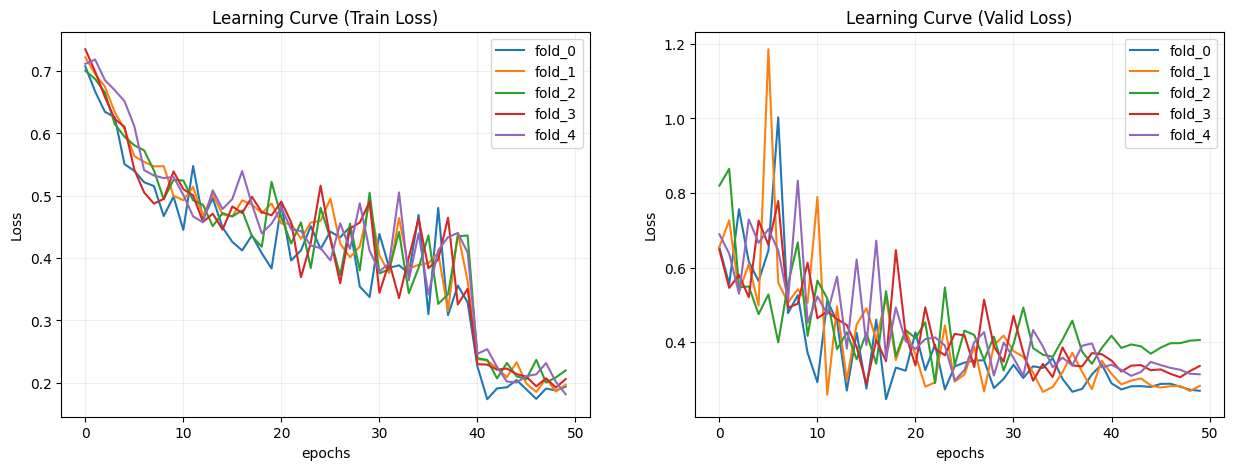

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

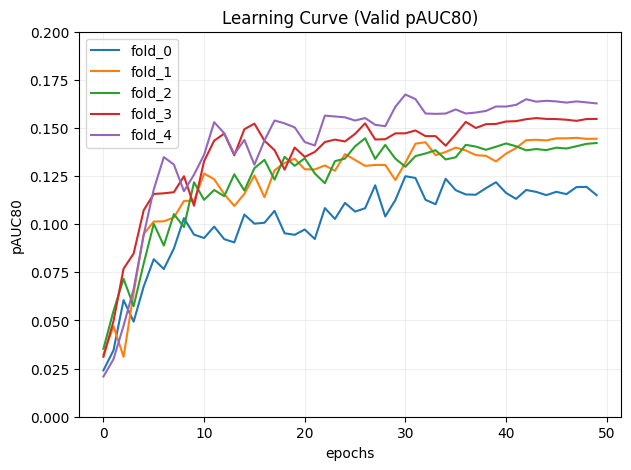

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [30]:
# data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
# table = wandb.Table(data=data, columns=["x", "y"])
# wandb.log(
#     {
#         "learning_curve_pAUC80": wandb.plot.line(
#             table, "x", "y", title="Learning Curve (Valid pAUC80)"
#         )
#     }
# )

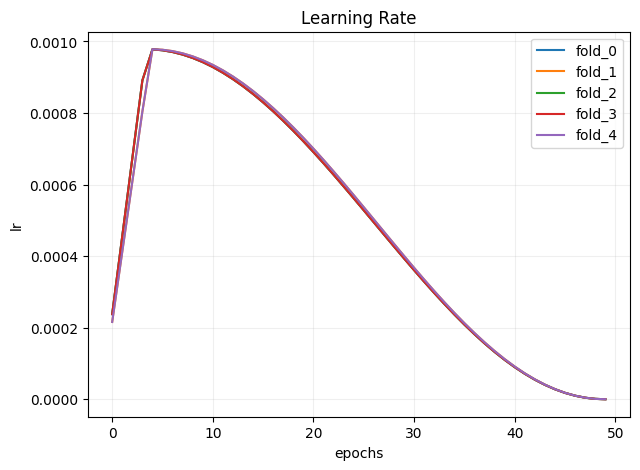

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [32]:
if CONFIG["save_preds"]:
    df_pred = pd.concat(list_preds)
    df_pred.to_csv(f"{CONFIG['save_dir']}/df_preds_{EXP_NAME}.csv", index=False)

In [33]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc["pAUC80_notFiltered"] = list_score_notFiltered
df_pauc.loc["mean", "pAUC80_notFiltered"] = np.mean(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["std", "pAUC80_notFiltered"] = np.std(df_pauc["pAUC80_notFiltered"])
df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc

,pAUC80,pAUC80_notFiltered
fold_0,0.1151,0.1152
fold_1,0.1444,0.1437
fold_2,0.1422,0.1393
fold_3,0.1547,0.1546
fold_4,0.1628,0.1595
mean,0.1438,0.1425
std,0.0147,0.0141


In [34]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.11509
pAUC80_fold1,0.14442
pAUC80_fold2,0.14219
pAUC80_fold3,0.1547
pAUC80_fold4,0.16276


In [35]:
# wandb.finish()